## TITANIC
ссылка на соревнование - https://www.kaggle.com/c/titanic

In [65]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

import re

from sklearn.model_selection import KFold, cross_val_score
from sklearn import preprocessing

In [2]:
data = pd.read_csv('train_titanic.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.columns = data.columns.str.lower()

## Исследование и подготовка данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
len(data.name[data.name.str.contains(', ')])

891

In [7]:
data = data.dropna(subset = ['embarked'], axis = 0)

In [8]:
data['sex'].replace({'female':0,'male':1}, inplace=True)

In [9]:
data.loc[data['age']<18, 'sex'] = 2

In [10]:
data.sample(5)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
225,226,0,3,"Berglund, Mr. Karl Ivar Sven",1,22.0,0,0,PP 4348,9.3500,NaN,S
489,490,1,3,"Coutts, Master. Eden Leslie ""Neville""",2,9.0,1,1,C.A. 37671,15.9000,NaN,S
560,561,0,3,"Morrow, Mr. Thomas Rowan",1,NaN,0,0,372622,7.7500,NaN,Q
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",0,48.0,1,0,11755,39.6000,A16,C
876,877,0,3,"Gustafsson, Mr. Alfred Ossian",1,20.0,0,0,7534,9.8458,NaN,S


In [11]:
data.sex.value_counts()

1    519
0    257
2    113
Name: sex, dtype: int64

In [12]:
print(len(data.ticket.unique()))
print(data.ticket.value_counts())
# признак ticket можно удалить

680
347082               7
1601                 7
CA. 2343             7
3101295              6
347088               6
                    ..
A/5 2817             1
PC 17756             1
110564               1
349249               1
STON/O 2. 3101293    1
Name: ticket, Length: 680, dtype: int64


In [13]:
print(len(data.cabin.unique()))

147


In [14]:
data['title'] = data.name.apply(lambda x: x.split(', ')[1].split()[0].replace('.',''))

In [15]:
data['title'].value_counts()

Mr          517
Miss        181
Mrs         124
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Don           1
the           1
Jonkheer      1
Lady          1
Sir           1
Ms            1
Mme           1
Capt          1
Name: title, dtype: int64

In [16]:
data[data.name.str.contains('Master')].sample(5)
# пассажиры с приставкой Master в имени - это в большинстве своём дети

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",1,NaN,1,1,2661,15.2458,NaN,C,Master
802,803,1,1,"Carter, Master. William Thornton II",2,11.00,1,2,113760,120.0000,B96 B98,S,Master
407,408,1,2,"Richards, Master. William Rowe",2,3.00,1,1,29106,18.7500,NaN,S,Master
755,756,1,2,"Hamalainen, Master. Viljo",2,0.67,1,1,250649,14.5000,NaN,S,Master
16,17,0,3,"Rice, Master. Eugene",2,2.00,4,1,382652,29.1250,NaN,Q,Master


In [17]:
def replace_titles(x):
    title=x['title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms', 'the']:
        return 'Miss'
    elif title =='Dr':
        if x['sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [18]:
data.title = data.apply(replace_titles, axis = 1)

In [19]:
data['surname'] = data['name'].apply(lambda x: re.split(', ', str(x))[0])
# можно избавиться от имени, оставить только фамилию

In [20]:
data = data.drop(['name', 'ticket', 'passengerid'], axis = 1)

In [21]:
features = ["pclass", "sex"]
pd.get_dummies(data, columns = features).sample(5)

,survived,age,sibsp,parch,fare,cabin,embarked,title,surname,pclass_1,pclass_2,pclass_3,sex_0,sex_1,sex_2
158,0,NaN,0,0,8.6625,NaN,S,Mr,Smiljanic,0,0,1,0,1,0
694,0,60.0,0,0,26.5500,NaN,S,Mr,Weir,1,0,0,0,1,0
806,0,39.0,0,0,0.0000,A36,S,Mr,Andrews,1,0,0,0,1,0
764,0,16.0,0,0,7.7750,NaN,S,Mr,Eklund,0,0,1,0,0,1
824,0,2.0,4,1,39.6875,NaN,S,Master,Panula,0,0,1,0,0,1


In [22]:
data.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname
510,1,3,1,29.0,0,0,7.7500,NaN,Q,Mr,Daly
473,1,2,0,23.0,0,0,13.7917,D,C,Mrs,Jerwan
19,1,3,0,NaN,0,0,7.2250,NaN,C,Mrs,Masselmani
321,0,3,1,27.0,0,0,7.8958,NaN,S,Mr,Danoff
754,1,2,0,48.0,1,2,65.0000,NaN,S,Mrs,Herman


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  889 non-null    int64  
 1   pclass    889 non-null    int64  
 2   sex       889 non-null    int64  
 3   age       712 non-null    float64
 4   sibsp     889 non-null    int64  
 5   parch     889 non-null    int64  
 6   fare      889 non-null    float64
 7   cabin     202 non-null    object 
 8   embarked  889 non-null    object 
 9   title     889 non-null    object 
 10  surname   889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [24]:
len(data.surname.unique())

665

In [25]:
len(data.surname)

889

In [26]:
data[data['age'].isnull()].sample(5)
# заполнить пропуски в возрасте можно на основе других признаков (группы признаков)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname
863,0,3,0,NaN,8,2,69.550,NaN,S,Miss,Sage
538,0,3,1,NaN,0,0,14.500,NaN,S,Mr,Risien
669,1,1,0,NaN,1,0,52.000,C126,S,Mrs,Taylor
19,1,3,0,NaN,0,0,7.225,NaN,C,Mrs,Masselmani
45,0,3,1,NaN,0,0,8.050,NaN,S,Mr,Rogers


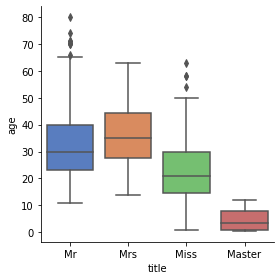

In [27]:
g = sns.catplot(x="title", y="age", data=data,
                height=4, kind="box", palette="muted")

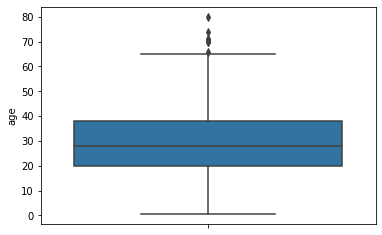

In [28]:
sns.boxplot(y = 'age', data = data)
plt.show()
# если заполнять пропуски в возрасте обшим средним

In [29]:
data.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
       'embarked', 'title', 'surname'],
      dtype='object')

In [30]:
# на основе нескольких признаков
data['family'] = (data['sibsp'] + data['parch']).apply(lambda x : 1 if x>0 else 0)
data['fare_round'] = 20*(data['fare']//20)
l_col = ['pclass','sex','family','title','fare_round']
data['age'] = data['age'].fillna(data.groupby(l_col)['age'].transform('mean').round(0))
# оставшиеся
data['age'] = data['age'].fillna(data.age.mean())

data = data.drop(columns = 'fare_round')

In [31]:
data[data.age.isnull()]

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname,family


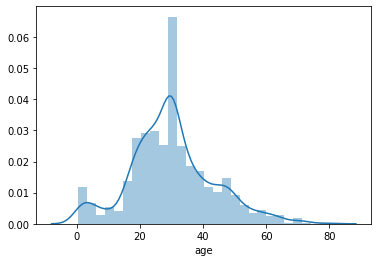

In [32]:
g = sns.distplot(data.age)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  889 non-null    int64  
 1   pclass    889 non-null    int64  
 2   sex       889 non-null    int64  
 3   age       889 non-null    float64
 4   sibsp     889 non-null    int64  
 5   parch     889 non-null    int64  
 6   fare      889 non-null    float64
 7   cabin     202 non-null    object 
 8   embarked  889 non-null    object 
 9   title     889 non-null    object 
 10  surname   889 non-null    object 
 11  family    889 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 130.3+ KB


In [33]:
col = [col for col in data.columns if ('port' not in col) and ('name' not in col)]
data[col].head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,family
0,0,3,1,22.0,1,0,7.2500,NaN,S,Mr,1
1,1,1,0,38.0,1,0,71.2833,C85,C,Mrs,1
2,1,3,0,26.0,0,0,7.9250,NaN,S,Miss,0
3,1,1,0,35.0,1,0,53.1000,C123,S,Mrs,1
4,0,3,1,35.0,0,0,8.0500,NaN,S,Mr,0


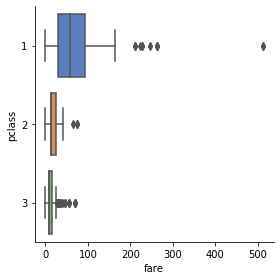

In [34]:
# проверить, если признаки 'pclass' и 'fare' зависимы
g = sns.catplot(y="pclass", x="fare", data=data, kind="box", palette="muted", orient ='h', height = 4)
# не зависимы, можно оставить оба признака

# чем отличаются люди, которые выжили и которые утонули

In [35]:
data.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname,family
571,1,1,0,53.0,2,0,51.4792,C101,S,Mrs,Appleton,1
363,0,3,1,35.0,0,0,7.0500,NaN,S,Mr,Asim,0
606,0,3,1,30.0,0,0,7.8958,NaN,S,Mr,Karaic,0
327,1,2,0,36.0,0,0,13.0000,D,S,Mrs,Ball,0
857,1,1,1,51.0,0,0,26.5500,E17,S,Mr,Daly,0


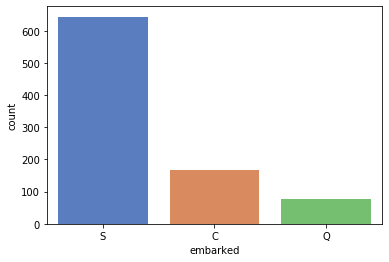

In [36]:
# признак embarked
g = sns.countplot(x = 'embarked', data = data, palette="muted")

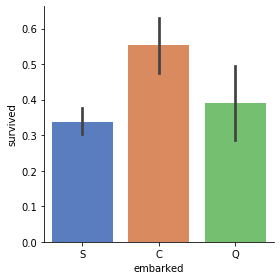

In [37]:
g = sns.catplot(x="embarked", y="survived", data=data,
                height=4, kind="bar", palette="muted")
# порт Cherbourg показывает больший процент выживших

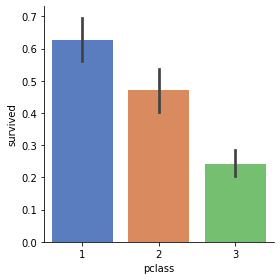

In [38]:
# класс билета
g = sns.catplot(x="pclass", y="survived", data=data,
                height=4, kind="bar", palette="muted")
# выживших в 1 классе больше

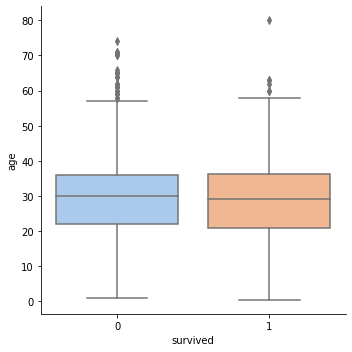

In [39]:
# возраст всех пассажиров
sns.catplot(x="survived", y="age", kind="box", data=data, palette="pastel");

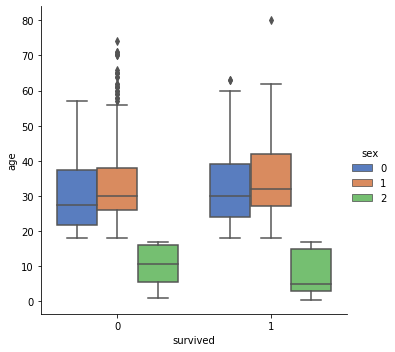

In [40]:
# с разделением по полу
sns.catplot(x="survived", y="age", hue ='sex', kind="box", data=data, palette="muted");
# выжившие женщины и мужчины в среднем старше утонувших
# среди выживших много маленьких детей

In [41]:
# пол
women = data.loc[data.sex == 0]["survived"]
rate_women = sum(women)/len(women)

print("# of women who survived:", rate_women)

# of women who survived: 0.7509727626459144


In [42]:
men = data.loc[data.sex == 1]["survived"]
rate_men = sum(men)/len(men)

print("# of men who survived:", rate_men)

# of men who survived: 0.16570327552986513


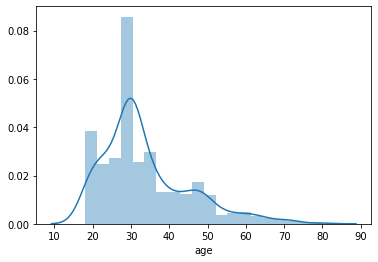

In [43]:
sns.distplot(data[data.sex == 1].age)
plt.show()
# мужчины

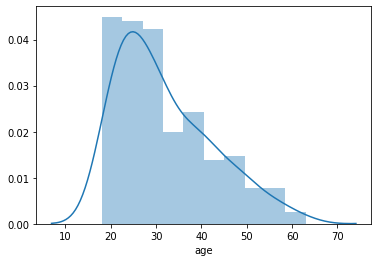

In [44]:
sns.distplot(data[data.sex == 0].age)
plt.show()
# женщины
# совсем старых нет

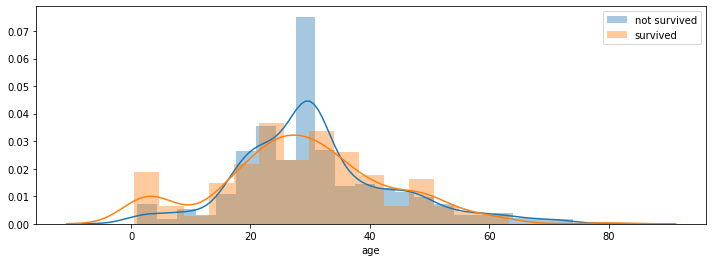

In [45]:
# зависит ли выживаемость от возраста
plt.figure(figsize = (12,4))
sns.distplot(data[data.survived == 0].age, label = 'not survived')
sns.distplot(data[data.survived == 1].age, label = 'survived')
plt.legend()
plt.show()

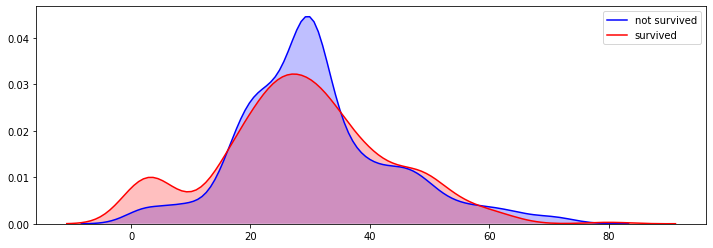

In [46]:
plt.figure(figsize = (12,4))
sns.kdeplot(data[data.survived == 0].age, label = 'not survived', color = 'b', shade = True)
sns.kdeplot(data[data.survived == 1].age, label = 'survived', color = 'red', shade = True)
plt.legend()
plt.show()
# до 18 лет - больше вероятность выжить
# от 18 до 35 лет - вероятность выжить небольшая
# после 35 лет - шансы примерно 50 на 50

поэтому для признака sex можно ввести категорию children (вверху)

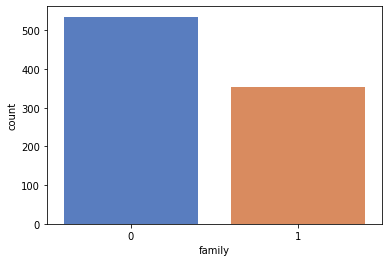

In [47]:
# наличие родственников на борту
g = sns.countplot(x = 'family', data = data, palette="muted")
plt.show()

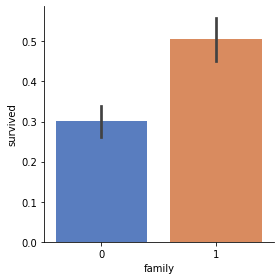

In [48]:
g = sns.catplot(x="family", y="survived", data=data,
                height=4, kind="bar", palette="muted")
# пассажиры с родственниками выжили в большем количестве 

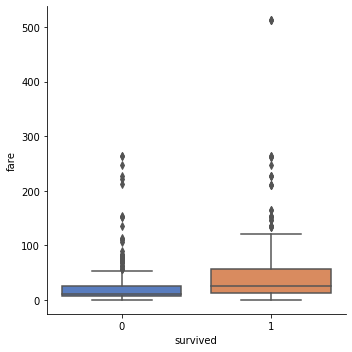

In [49]:
# плата за билет
sns.catplot(x="survived", y="fare", kind="box", data=data, palette="muted");
# у выживших плата за проезд существенно выше, чем у утонувших

# Список методов

`NON-TREE MODELS` \
**метрический** - метод ближайших соседей 

**линейный** - метод опорных векторов (только если линейно разделима выборка) \
**+** - для SVM сделать PCA \
**линейный** - логистическая регрессия 

`TREE MODELS` \
одно решающее дерево \
градиентный бустинг \
случайный лес

`OTHERS` \
нейронные сети
_______________
кросс-валидация на тесте

In [50]:
data.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname,family
843,0,3,1,34.5,0,0,6.4375,NaN,C,Mr,Lemberopolous,0
562,0,2,1,28.0,0,0,13.5000,NaN,S,Mr,Norman,0
745,0,1,1,70.0,1,1,71.0000,B22,S,Mr,Crosby,1
14,0,3,2,14.0,0,0,7.8542,NaN,S,Miss,Vestrom,0
199,0,2,0,24.0,0,0,13.0000,NaN,S,Miss,Yrois,0


# дерево решений (логический метод)

In [51]:
y = data['survived']
X = data.drop(['survived','surname'], axis=1)

In [52]:
X['fare_per_pers'] = (X['fare'] / (X['sibsp'] + X['parch']+ 1)).round(2)

In [53]:
X.sample(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,family,fare_per_pers
773,3,1,30.0,0,0,7.2250,NaN,C,Mr,0,7.22
135,2,1,23.0,0,0,15.0458,NaN,C,Mr,0,15.05
366,1,0,60.0,1,0,75.2500,D37,C,Mrs,1,37.62
313,3,1,28.0,0,0,7.8958,NaN,S,Mr,0,7.90
112,3,1,22.0,0,0,8.0500,NaN,S,Mr,0,8.05


In [54]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         889 non-null    int64  
 1   sex            889 non-null    int64  
 2   age            889 non-null    float64
 3   sibsp          889 non-null    int64  
 4   parch          889 non-null    int64  
 5   fare           889 non-null    float64
 6   cabin          202 non-null    object 
 7   embarked       889 non-null    object 
 8   title          889 non-null    object 
 9   family         889 non-null    int64  
 10  fare_per_pers  889 non-null    float64
dtypes: float64(3), int64(5), object(3)
memory usage: 123.3+ KB


In [55]:
X.embarked.value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [59]:
# le = preprocessing.LabelEncoder()
# X.embarked = le.fit_transform(X.embarked)

# это label encoding для embarked
# вариант 1

In [56]:
encoding = X.groupby('embarked').size()
encoding = encoding/len(X)
X['emb_enc'] = X.embarked.map(encoding)
X.drop(['embarked'], axis = 1, inplace = True)

# это frequency encoding для embarked
# вариант 2

In [57]:
X.cabin.fillna('-', inplace = True)

In [58]:
X['cabin'] = X.cabin.apply(lambda x: x[0])

In [59]:
X.cabin.value_counts()

-    687
C     59
B     45
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin, dtype: int64

In [61]:
# le = preprocessing.LabelEncoder()
# X.cabin = le.fit_transform(X.cabin)
# это label encoding для cabin
# вариант 1

In [62]:
encoding = X.groupby('cabin').size()
encoding = encoding/len(X)
X['cab_enc'] = X.cabin.map(encoding)
X.drop(['cabin'], inplace = True, axis = 1)

# это frequency encoding для cabin
# вариант 2

In [63]:
X.title.value_counts()

Mr        531
Miss      185
Mrs       133
Master     40
Name: title, dtype: int64

In [66]:
le = preprocessing.LabelEncoder()
X.title = le.fit_transform(X.title)
# это label encoding для title
# вариант 1

In [67]:
# encoding = X.groupby('title').size() / len(X)
# X['tit_enc'] = X.title.map(encoding)
# X.drop(['title'], inplace = True, axis = 1)

# это frequency encoding для title
# вариант 2

In [67]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         889 non-null    int64  
 1   sex            889 non-null    int64  
 2   age            889 non-null    float64
 3   sibsp          889 non-null    int64  
 4   parch          889 non-null    int64  
 5   fare           889 non-null    float64
 6   title          889 non-null    int64  
 7   family         889 non-null    int64  
 8   fare_per_pers  889 non-null    float64
 9   emb_enc        889 non-null    float64
 10  cab_enc        889 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 123.3 KB


In [68]:
X.sample(5)

,pclass,sex,age,sibsp,parch,fare,title,family,fare_per_pers,emb_enc,cab_enc
808,2,1,39.0,0,0,13.0000,2,0,13.00,0.724409,0.772778
388,3,1,30.0,0,0,7.7292,2,0,7.73,0.086614,0.772778
733,2,1,23.0,0,0,13.0000,2,0,13.00,0.724409,0.772778
4,3,1,35.0,0,0,8.0500,2,0,8.05,0.724409,0.772778
81,3,1,29.0,0,0,9.5000,2,0,9.50,0.724409,0.772778


In [69]:
from sklearn.tree import DecisionTreeClassifier

kf = KFold(n_splits = 5, random_state=42, shuffle=True)

for depth in [2,3,4,5]:
    model_tree = DecisionTreeClassifier(max_depth=depth)
    score = cross_val_score(model_tree, X = X, y = y, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis=0)
    print('depth - {}, score - {}'.format(depth, score_norm))

depth - 2, score - 0.7918936075668126
depth - 3, score - 0.8245223132101822
depth - 4, score - 0.814384561670793
depth - 5, score - 0.82228781819336


наилучший результат - 0.824

In [71]:
# from sklearn.tree import export_graphviz

In [72]:
# model_tree.fit(X,y)

In [73]:
# export_graphviz(model_tree, feature_names = ['pclass','sex','age','sibsp','parch','fare','cabin','amb_enc',\
#                                              'surname','family_size', 'fare_per_pers', 'tit_enc'], out_file = 'tree.dot', filled = True)

# случайный лес

In [70]:
from sklearn.ensemble import RandomForestClassifier

score_ar = np.array([])
estim = [10,20,30,40,50,80,100,150]
for k in estim:
    #     обратить внимание на max_features, max_samples
    clf_rf = RandomForestClassifier(n_estimators = k, random_state = 1, max_samples = 0.4)
    score = cross_val_score(clf_rf, X = X, y = y, cv = kf, scoring ='accuracy')
    score_norm = np.mean(score, axis=0)
    score_ar = np.append(score_ar,score_norm)
k_optimal = np.argmax(score_ar)
print (estim[k_optimal])
print(score_ar[k_optimal])

150
0.8245096172157684


# градиентный бустинг

In [71]:
# работает быстро, ограничений на глубину не требуется
# масштабирование тоже не требуется
from sklearn.ensemble import GradientBoostingClassifier

score_ar = np.array([])
estim = [10,20,30,40,50,80,100,150]
for k in estim:
    #     обратить внимание на max_features и подвыборку объектов (subsample)
    clf = GradientBoostingClassifier(n_estimators=k, random_state=241, subsample = 1.0)
    score = cross_val_score(clf, X = X, y = y, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis=0)
    score_ar = np.append(score_ar,score_norm)
k_optimal = np.argmax(score_ar)
print('k - {}, score - {}'.format(estim[k_optimal], score_ar[k_optimal]))

k - 40, score - 0.8425188852916904


In [72]:
X.sample(5)

,pclass,sex,age,sibsp,parch,fare,title,family,fare_per_pers,emb_enc,cab_enc
681,1,1,27.0,0,0,76.7292,2,0,76.73,0.188976,0.037120
242,2,1,29.0,0,0,10.5000,2,0,10.50,0.724409,0.772778
327,2,0,36.0,0,0,13.0000,3,0,13.00,0.724409,0.037120
16,3,2,2.0,4,1,29.1250,0,1,4.85,0.086614,0.772778
466,2,1,34.0,0,0,0.0000,2,0,0.00,0.724409,0.772778


# ближайшие соседи (метрический метод)

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  889 non-null    int64  
 1   pclass    889 non-null    int64  
 2   sex       889 non-null    int64  
 3   age       889 non-null    float64
 4   sibsp     889 non-null    int64  
 5   parch     889 non-null    int64  
 6   fare      889 non-null    float64
 7   cabin     202 non-null    object 
 8   embarked  889 non-null    object 
 9   title     889 non-null    object 
 10  surname   889 non-null    object 
 11  family    889 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 130.3+ KB


In [74]:
data.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname,family
853,1,1,2,16.0,0,1,39.4000,D28,S,Miss,Lines,1
226,1,2,1,19.0,0,0,10.5000,NaN,S,Mr,Mellors,0
710,1,1,0,24.0,0,0,49.5042,C90,C,Miss,Mayne,0
233,1,3,2,5.0,4,2,31.3875,NaN,S,Miss,Asplund,1
312,0,2,0,26.0,1,1,26.0000,NaN,S,Mrs,Lahtinen,1


In [75]:
yl = data['survived']
Xl = data.drop(['survived', 'surname'], axis = 1)

In [76]:
Xl['fare_per_pers'] = Xl['fare'] / (Xl['sibsp'] + Xl['parch'] + 1)

In [77]:
Xl.sample(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,family,fare_per_pers
410,3,1,30.0,0,0,7.8958,NaN,S,Mr,0,7.8958
766,1,1,32.0,0,0,39.6000,NaN,C,Mrs,0,39.6000
169,3,1,28.0,0,0,56.4958,NaN,S,Mr,0,56.4958
551,2,1,27.0,0,0,26.0000,NaN,S,Mr,0,26.0000
424,3,1,18.0,1,1,20.2125,NaN,S,Mr,1,6.7375


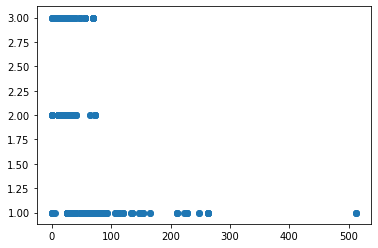

In [78]:
plt.scatter(Xl.fare, Xl.pclass);

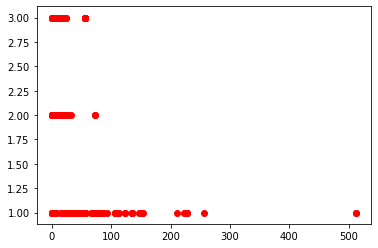

In [79]:
plt.scatter(Xl.fare_per_pers, Xl.pclass, c= 'r');

In [80]:
Xl = Xl.join(pd.get_dummies(Xl.embarked, prefix='port')).drop(['embarked'], axis = 1)
Xl = Xl.join(pd.get_dummies(Xl.title, prefix='title')).drop(['title'], axis = 1)

In [81]:
Xl.cabin.fillna('-', inplace = True)
Xl['cabin'] = Xl.cabin.apply(lambda x: x[0])

In [82]:
Xl.cabin.value_counts()

-    687
C     59
B     45
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin, dtype: int64

In [83]:
Xl = Xl.join(pd.get_dummies(Xl.cabin, prefix='cabin')).drop(['cabin'], axis = 1)

In [84]:
Xl.sample(5)

,pclass,sex,age,sibsp,parch,fare,family,fare_per_pers,port_C,port_Q,...,title_Mrs,cabin_-,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T
356,1,0,22.0,0,1,55.0000,1,27.500000,0,0,...,0,0,0,0,0,0,1,0,0,0
524,3,1,30.0,0,0,7.2292,0,7.229200,1,0,...,0,1,0,0,0,0,0,0,0,0
582,2,1,54.0,0,0,26.0000,0,26.000000,0,0,...,0,1,0,0,0,0,0,0,0,0
36,3,1,30.0,0,0,7.2292,0,7.229200,1,0,...,0,1,0,0,0,0,0,0,0,0
248,1,1,37.0,1,1,52.5542,1,17.518067,0,0,...,0,0,0,0,0,1,0,0,0,0


In [85]:
data.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,surname,family
763,1,1,0,36.0,1,2,120.0000,B96 B98,S,Mrs,Carter,1
692,1,3,1,30.0,0,0,56.4958,NaN,S,Mr,Lam,0
888,0,3,0,21.0,1,2,23.4500,NaN,S,Miss,Johnston,1
838,1,3,1,32.0,0,0,56.4958,NaN,S,Mr,Chip,0
354,0,3,1,30.0,0,0,7.2250,NaN,C,Mr,Yousif,0


In [86]:
from sklearn.neighbors import KNeighborsClassifier

In [87]:
kf = KFold(n_splits = 5, random_state=42, shuffle=True)

In [88]:
# без масштбаирования результат плохой
score_ar = np.array([])
for k in range(1,51):
    k_classifier = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(k_classifier, X=Xl, y=yl, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis = 0)
    score_ar = np.append(score_ar, score_norm)
k_optimal = np.argmax(score_ar)+1
print('k - {}, score - {}'.format(k_optimal, score_ar[k_optimal-1]))

k - 12, score - 0.7424046213419666


In [89]:
# с масштабирвоанием результат лучше
from sklearn.preprocessing import scale 
scaled_Xl = scale(Xl)

score_ar = np.array([])
for k in range(1,51):
    k_classifier = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(k_classifier, X = scaled_Xl, y=yl, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis=0) #or average
    score_ar = np.append(score_ar, score_norm)
k_optimal = np.argmax(score_ar)+1
print (k_optimal)
print('k - {}, score - {}'.format(k_optimal, score_ar[k_optimal-1]))

18
k - 18, score - 0.8222624262045326


# логистическая регрессия (линейный метод)

### c PCA(метод главных компонент)

In [90]:
from sklearn.decomposition import PCA

pca = PCA(.95)
pca.fit(scaled_Xl)

pca.n_components_

17

In [91]:
scaled_Xl_pca = pca.transform(scaled_Xl)

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

for c in np.logspace(-2,2, num = 5):
    clf_lr = LogisticRegression(C = c, random_state = 241)
    score = cross_val_score(clf_lr, X = scaled_Xl_pca, y = yl, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis=0)
    print('c - {}, score - {}'.format(c, score_norm))

c - 0.01, score - 0.8065130451342603
c - 0.1, score - 0.8199834952072621
c - 1.0, score - 0.8222370342157049
c - 10.0, score - 0.821113438710087
c - 100.0, score - 0.8233606297213228


лучший результат - 0.82

### без PCA

In [93]:
for c in np.logspace(-2,2, num = 5):
    clf_lr = LogisticRegression(C = c, random_state = 241)
    score = cross_val_score(clf_lr, X = scaled_Xl, y = yl, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis=0)
    print('c - {}, score - {}'.format(c, score_norm))

c - 0.01, score - 0.8143718656763792
c - 0.1, score - 0.8188535517044372
c - 1.0, score - 0.8233415857297024
c - 10.0, score - 0.8222179902240843
c - 100.0, score - 0.8233415857297024


лучший результат - 0.82

# метод опорных векторов (линейный метод)

In [94]:
from sklearn.svm import SVC

for c in np.logspace(-2,1,num=4):
    clf_svm = SVC(C = c, random_state=241, kernel='rbf')
    score = cross_val_score(clf_svm, X = scaled_Xl, y = yl, cv = kf, scoring = 'accuracy')
    score_norm = np.mean(score, axis=0)
    print('c - {}, score - {}'.format(c, score_norm))

c - 0.01, score - 0.6175903002602678
c - 0.1, score - 0.7738208595188218
c - 1.0, score - 0.8301148987494444
c - 10.0, score - 0.824528661207389


лучший результат - 0.83

# перспетрон (нейронные сети)

In [95]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split

Xl_train, Xl_test, yl_train, yl_test = train_test_split(scaled_Xl, yl, test_size=0.33, random_state=42)

clf_nn = Perceptron(random_state=241, shuffle = True, max_iter=2000, tol=None)
clf_nn.fit(Xl_train, yl_train)
predictions = clf_nn.predict(Xl_test)
print(accuracy_score(yl_test, predictions))

0.6904761904761905


# проверка на тесте
### подготовка данных для градиентного бустинга

In [96]:
data_test = pd.read_csv('test_titanic.csv')
data_test.columns = data_test.columns.str.lower()

In [97]:
data_test.head()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [98]:
X_test = data_test.drop(columns = ['ticket'])
X_test['title'] = X_test.name.apply(lambda x: x.split(', ')[1].split()[0].replace('.',''))
X_test.title = X_test.apply(replace_titles, axis = 1)
X_test['sex'].replace({'female':0,'male':1}, inplace=True)
X_test['fare'].fillna(X_test.fare.mean(), inplace = True)
X_test['fare_per_pers'] = X_test['fare'] / (X_test['sibsp'] + X_test['parch'] + 1)

In [99]:
X_test.loc[X_test['age']<18, 'sex'] = 2

In [108]:
# le = preprocessing.LabelEncoder()
# X_test.embarked = le.fit_transform(X_test.embarked)

# label encoding для embarked
# вариант 1

In [100]:
encoding = X_test.groupby('embarked').size()
encoding = encoding/len(X_test)
X_test['emb_enc'] = X_test.embarked.map(encoding)
X_test.drop(['embarked'], axis = 1, inplace = True)

# это frequency encoding для embarked
# вариант 2

In [101]:
X_test = X_test.drop(['name', 'passengerid'], axis = 1)

In [102]:
X_test.sample(5)

,pclass,sex,age,sibsp,parch,fare,cabin,title,fare_per_pers,emb_enc
403,1,2,17.0,0,0,47.10,NaN,Mr,47.10,0.645933
410,3,0,NaN,0,0,7.75,NaN,Miss,7.75,0.110048
388,3,1,21.0,0,0,7.75,NaN,Mr,7.75,0.110048
78,2,1,30.0,0,0,13.00,NaN,Mr,13.00,0.645933
298,1,1,30.0,0,0,45.50,NaN,Mr,45.50,0.645933


In [103]:
# восстанавливаем возраст
X_test['family'] = (X_test['sibsp'] + X_test['parch']).apply(lambda x : 1 if x>0 else 0)
X_test['fare_round'] = 20*(X_test['fare']//20)
l_col = ['pclass','sex','family','title','fare_round']
X_test['age'] = X_test['age'].fillna(X_test.groupby(l_col)['age'].transform('mean').round(0))
# оставшиеся
X_test['age'] = X_test['age'].fillna(X_test.age.mean())

X_test = X_test.drop(columns = 'fare_round')

In [104]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         418 non-null    int64  
 1   sex            418 non-null    int64  
 2   age            418 non-null    float64
 3   sibsp          418 non-null    int64  
 4   parch          418 non-null    int64  
 5   fare           418 non-null    float64
 6   cabin          91 non-null     object 
 7   title          418 non-null    object 
 8   fare_per_pers  418 non-null    float64
 9   emb_enc        418 non-null    float64
 10  family         418 non-null    int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 36.0+ KB


In [105]:
X_test.cabin.fillna('-', inplace = True)
X_test['cabin'] = X_test.cabin.apply(lambda x: x[0])

In [106]:
# le = preprocessing.LabelEncoder()
# X_test.cabin = le.fit_transform(X_test.cabin)
# # это label encoding для cabin


encoding = X_test.groupby('cabin').size()
# get frequency of each category
encoding = encoding/len(X_test)
X_test['cab_enc'] = X_test.cabin.map(encoding)
X_test.drop(['cabin'], inplace = True, axis = 1)

# это frequency encoding для cabin

In [107]:
le = preprocessing.LabelEncoder()
X_test.title = le.fit_transform(X_test.title)

# это label encoding для title

In [108]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         418 non-null    int64  
 1   sex            418 non-null    int64  
 2   age            418 non-null    float64
 3   sibsp          418 non-null    int64  
 4   parch          418 non-null    int64  
 5   fare           418 non-null    float64
 6   title          418 non-null    int64  
 7   fare_per_pers  418 non-null    float64
 8   emb_enc        418 non-null    float64
 9   family         418 non-null    int64  
 10  cab_enc        418 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 36.0 KB


### Модель градиентного бустинга

In [121]:
clf = GradientBoostingClassifier(n_estimators=40, random_state=241)
clf.fit(X, y)
y_predict = clf.predict(X_test)

In [122]:
d = {'PassengerId':data_test['passengerid'], 'Survived':y_predict}
df = pd.DataFrame(data = d)
df.sample(5)

,PassengerId,Survived
52,944,1
374,1266,1
336,1228,0
388,1280,0
208,1100,1


In [123]:
df.to_csv('TITANIC_result', index = False)

In [124]:
len(df)

418

# RESULT - 0.79425
модель - градиентный бустинг \
для embarked, cabin использовался frequency encoding
для title - label encoding

### Подготовка данных для логистической регрессии

In [212]:
X_test = data_test.drop(columns = ['ticket'])
X_test['title'] = X_test.name.apply(lambda x: x.split(', ')[1].split()[0].replace('.',''))
X_test.title = X_test.apply(replace_titles, axis = 1)
X_test['sex'].replace({'female':0,'male':1}, inplace=True)
X_test['fare'].fillna(X_test.fare.mean(), inplace = True)

In [213]:
X_test.loc[X_test['age']<18, 'sex'] = 2

In [214]:
X_test = X_test.drop(['name', 'passengerid'], axis = 1)

In [215]:
X_test.sample(5)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
399,3,1,31.0,0,0,7.7333,NaN,Q,Mr
369,2,1,29.0,0,0,13.8583,NaN,C,Mr
291,3,0,30.0,0,0,6.9500,NaN,Q,Miss
414,1,0,39.0,0,0,108.9000,C105,C,Mrs
392,3,2,13.0,0,2,20.2500,NaN,S,Master


In [216]:
# восстанавливаем возраст
X_test['family'] = (X_test['sibsp'] + X_test['parch']).apply(lambda x : 1 if x>0 else 0)
X_test['fare_round'] = 20*(X_test['fare']//20)
l_col = ['pclass','sex','family','title','fare_round']
X_test['age'] = X_test['age'].fillna(X_test.groupby(l_col)['age'].transform('mean').round(0))
# оставшиеся
X_test['age'] = X_test['age'].fillna(X_test.age.mean())

X_test = X_test.drop(columns = 'fare_round')

In [217]:
X_test['fare_per_pers'] = X_test['fare'] / (X_test['sibsp'] + X_test['parch'] + 1)

In [218]:
X_test = X_test.join(pd.get_dummies(X_test.embarked, prefix='port')).drop(['embarked'], axis = 1)

In [219]:
X_test.cabin.fillna('-', inplace = True)
X_test['cabin'] = X_test.cabin.apply(lambda x: x[0])

In [220]:
X_test.cabin.value_counts()
# нет кабин, начинающихся на T, как в тестовой выборке

-    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: cabin, dtype: int64

In [221]:
X_test = X_test.join(pd.get_dummies(X_test.title, prefix='title')).drop(['title'], axis = 1)

In [222]:
X_test = X_test.join(pd.get_dummies(X_test.cabin, prefix='cabin'))
X_test['cabin_T'] = 0
X_test = X_test.drop(['cabin'], axis = 1)

In [223]:
X_test.sample(5)

,pclass,sex,age,sibsp,parch,fare,family,fare_per_pers,port_C,port_Q,...,title_Mrs,cabin_-,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T
114,1,0,63.0,1,0,221.7792,1,110.8896,0,0,...,1,0,0,0,1,0,0,0,0,0
382,3,0,34.0,0,0,14.5000,0,14.5000,0,0,...,1,1,0,0,0,0,0,0,0,0
195,3,1,33.0,0,0,7.8542,0,7.8542,0,0,...,0,1,0,0,0,0,0,0,0,0
166,1,1,48.0,0,0,50.4958,0,50.4958,1,0,...,0,0,0,1,0,0,0,0,0,0
290,1,1,40.0,0,0,39.6000,0,39.6000,0,0,...,0,1,0,0,0,0,0,0,0,0


In [224]:
scaled_X_test = scale(X_test)

In [225]:
X_test.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'family',
       'fare_per_pers', 'port_C', 'port_Q', 'port_S', 'title_Master',
       'title_Miss', 'title_Mr', 'title_Mrs', 'cabin_-', 'cabin_A', 'cabin_B',
       'cabin_C', 'cabin_D', 'cabin_E', 'cabin_F', 'cabin_G', 'cabin_T'],
      dtype='object')

In [226]:
Xl.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'family',
       'fare_per_pers', 'port_C', 'port_Q', 'port_S', 'title_Master',
       'title_Miss', 'title_Mr', 'title_Mrs', 'cabin_-', 'cabin_A', 'cabin_B',
       'cabin_C', 'cabin_D', 'cabin_E', 'cabin_F', 'cabin_G', 'cabin_T'],
      dtype='object')

### Модель логистической регрессии

In [227]:
clf_lr = LogisticRegression(C = 1.0, random_state = 241)
clf_lr.fit(scaled_Xl, yl)
y_predict = clf_lr.predict(scaled_X_test)

In [228]:
d = {'PassengerId':data_test['passengerid'], 'Survived':y_predict}
df = pd.DataFrame(data = d)
df.sample(5)

,PassengerId,Survived
25,917,0
162,1054,1
163,1055,0
20,912,0
128,1020,0


In [229]:
df.to_csv('TITANIC_result', index = False)

In [230]:
len(df)

418

# RESULT - 0.75837
модель - логистическая регресиия \
для embarked,cabin,title использовался one-hot encoding